Dataset original:
   x1  x2 tipo
0   0   0    A
1   1   0    B
2   0   1    B
3   1   1    C

Dataset con valores faltantes (para IMPUTACIÓN):
    x1  x2 tipo
0  0.0   0    A
1  NaN   0    B
2  0.0   1  NaN
3  1.0   1    C

Matriz de entrada concatenada (X_full):
[[-0.81649658 -1.          1.          0.          0.        ]
 [ 0.         -1.          0.          1.          0.        ]
 [-0.81649658  1.          1.          0.          0.        ]
 [ 1.63299316  1.          0.          0.          1.        ]]

Transpuesta de la entrada (X_full_T):
[[-0.81649658  0.         -0.81649658  1.63299316]
 [-1.         -1.          1.          1.        ]
 [ 1.          0.          1.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]

COMPUERTA LÓGICA: OR
Entropía de Shannon de la salida OR: 0.8113 bits

[Perceptrón (1 capa)] Métricas:
Accuracy: 1.0000
Matriz de confusión:
[[1 0]
 [0 3]]
Reporte de clasificación:
     

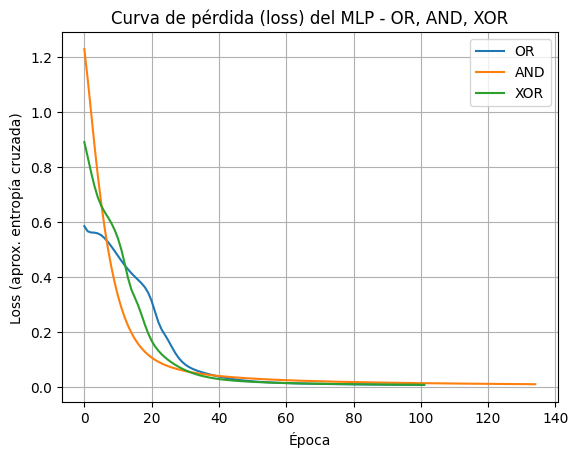

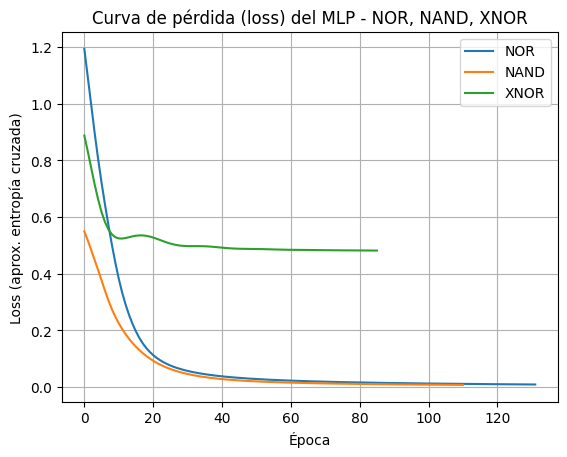

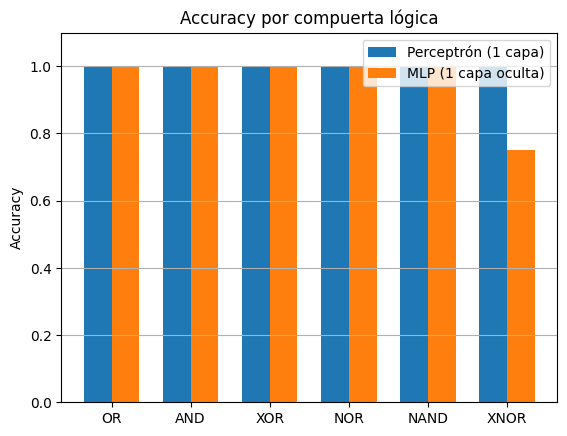

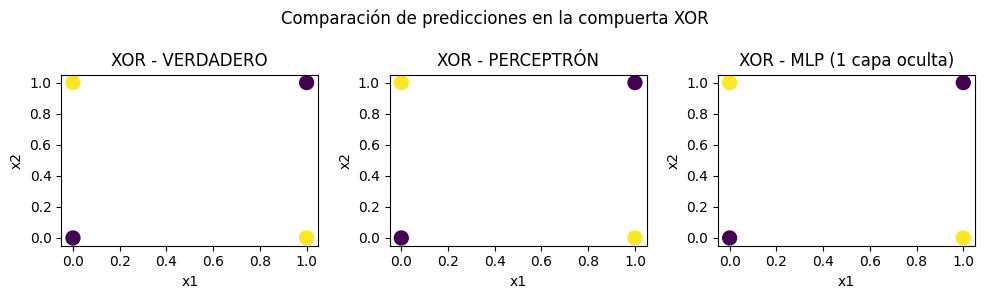

In [4]:
# ============================================
# PASO 1: Cargar librerías
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron           # Perceptrón (1 sola capa)
from sklearn.neural_network import MLPClassifier      # MLP (1 sola capa oculta)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

# ============================================
# PASO 2: Definir funciones auxiliares
#  - entropía de Shannon
#  - función para imprimir métricas
# ============================================
def entropia_shannon(y):
    """Calcula entropía de Shannon en bits para una variable binaria."""
    valores, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return -np.sum(p * np.log2(p))

def imprimir_metricas(nombre_modelo, y_true, y_pred):
    print(f"\n[{nombre_modelo}] Métricas:")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Matriz de confusión:")
    print(cm)
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred))
    return acc

# ============================================
# DATOS BASE: tabla de verdad + variable categórica
# (para poder hacer imputación y codificación)
# ============================================

# Entradas binarias (todas las combinaciones)
X_base = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])

# Variable categórica asociada (solo para ejemplo de One-Hot + imputación)
tipo = np.array(['A', 'B', 'B', 'C'])

df = pd.DataFrame({
    'x1': X_base[:, 0],
    'x2': X_base[:, 1],
    'tipo': tipo
})

# Introducimos NaN para demostrar IMPUTACIÓN
df_missing = df.copy()
df_missing.loc[1, 'x1'] = np.nan    # valor numérico faltante
df_missing.loc[2, 'tipo'] = np.nan  # valor categórico faltante

print("Dataset original:")
print(df)
print("\nDataset con valores faltantes (para IMPUTACIÓN):")
print(df_missing)

# ============================================
# TODAS LAS COMPUERTAS LÓGICAS
# ============================================
targets = {
    'OR'   : np.array([0, 1, 1, 1]),
    'AND'  : np.array([0, 0, 0, 1]),
    'XOR'  : np.array([0, 1, 1, 0]),
    'NOR'  : np.array([1, 0, 0, 0]),
    'NAND' : np.array([1, 1, 1, 0]),
    'XNOR' : np.array([1, 0, 0, 1])
}

# ============================================
# PASO 3: Definir intervalo (épocas del MLP)
# ============================================
epocas = 500   # máximo de iteraciones de entrenamiento del MLP

# ============================================
# PASO 4: Normalización de datos
#  + imputación
#  + codificación
# ============================================

# Separamos parte numérica y categórica
X_num = df_missing[['x1', 'x2']].values.astype(float)
X_cat = df_missing[['tipo']].values

# --- Imputación numérica ---
imputer_num = SimpleImputer(strategy='mean')
X_num_imp = imputer_num.fit_transform(X_num)

# --- Normalización (escalado) de los datos numéricos ---
scaler = StandardScaler()
X_num_norm = scaler.fit_transform(X_num_imp)

# --- Imputación categórica ---
imputer_cat = SimpleImputer(strategy='most_frequent')
X_cat_imp = imputer_cat.fit_transform(X_cat)

# --- Codificación One-Hot ---
# En versiones nuevas de scikit-learn (como en Google Colab) se usa 'sparse_output'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_enc = encoder.fit_transform(X_cat_imp)

# ============================================
# PASO 5: Transponer y concatenar la entrada
#  (se concatena numérico normalizado + categórico codificado)
# ============================================
X_full = np.hstack([X_num_norm, X_cat_enc])   # concatenar características
X_full_T = X_full.T                           # transpuesta (solo para inspección)

print("\nMatriz de entrada concatenada (X_full):")
print(X_full)
print("\nTranspuesta de la entrada (X_full_T):")
print(X_full_T)

# Usaremos X_full como entrada para Perceptrón y MLP
# (forma: n_muestras x n_características)

# Para guardar resultados de todas las compuertas
resultados = {}

# ============================================
# BUCLE SOBRE TODAS LAS COMPUERTAS
# Dentro del bucle se siguen los PASOS 6–10 para el MLP
# ============================================

for nombre, y in targets.items():
    print("\n======================================")
    print(f"COMPUERTA LÓGICA: {nombre}")
    print("======================================")

    # Entropía de la salida de la compuerta
    H = entropia_shannon(y)
    print(f"Entropía de Shannon de la salida {nombre}: {H:.4f} bits")

    # ============================================
    # PERCEPTRÓN (red neuronal de una sola capa)
    # ============================================
    perc = Perceptron(max_iter=1000, random_state=0)
    perc.fit(X_full, y)
    y_pred_perc = perc.predict(X_full)
    acc_perc = imprimir_metricas("Perceptrón (1 capa)", y, y_pred_perc)

    # ============================================
    # PASO 6: Crear el modelo de la red (MLP)
    # PASO 7: Definir los hiperparámetros del MLP
    #   - 1 sola capa oculta: hidden_layer_sizes=(N,)
    #   - activation, solver, learning_rate_init, max_iter, etc.
    # ============================================
    mlp = MLPClassifier(
        hidden_layer_sizes=(1,),   # *** SOLO UNA CAPA OCULTA con 1 neurona ***
        activation='tanh',         # función de activación
        solver='adam',             # optimizador
        learning_rate_init=0.1,    # tasa de aprendizaje
        max_iter=epocas,           # PASO 3: intervalo de épocas
        random_state=0
    )

    # Entrenamiento del MLP
    mlp.fit(X_full, y)

    # ============================================
    # PASO 8: Evaluar y graficar el error por época
    #  (usamos loss_curve_ del MLP)
    # ============================================
    loss_curve = mlp.loss_curve_  # lista de pérdida por iteración

    print(f"\nNúmero de épocas realizadas por el MLP en {nombre}: {len(loss_curve)}")

    # ============================================
    # PASO 9: Definir los datos de prueba
    #  Para compuertas lógicas, usamos las mismas combinaciones de entrada
    # ============================================
    X_test = X_full
    y_test = y

    # ============================================
    # PASO 10: Evaluar el modelo y graficar el resultado
    # ============================================
    y_pred_mlp = mlp.predict(X_test)
    y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

    acc_mlp = imprimir_metricas("MLP (1 capa oculta)", y_test, y_pred_mlp)
    logloss_mlp = log_loss(y_test, y_proba_mlp)
    print(f"Entropía cruzada (log-loss) del MLP para {nombre}: {logloss_mlp:.4f}")

    # Guardamos resultados para gráficas globales
    resultados[nombre] = {
        'y_true': y_test,
        'y_pred_perc': y_pred_perc,
        'y_pred_mlp': y_pred_mlp,
        'acc_perc': acc_perc,
        'acc_mlp': acc_mlp,
        'logloss_mlp': logloss_mlp,
        'loss_curve': loss_curve
    }

# ============================================
# GRÁFICA 1: Curvas de error (loss) por época
#  MLP para OR, AND, XOR
# ============================================
plt.figure()
for nombre in ['OR', 'AND', 'XOR']:
    plt.plot(resultados[nombre]['loss_curve'], label=nombre)
plt.title('Curva de pérdida (loss) del MLP - OR, AND, XOR')
plt.xlabel('Época')
plt.ylabel('Loss (aprox. entropía cruzada)')
plt.legend()
plt.grid(True)
plt.show()

# ============================================
# GRÁFICA 2: Curvas de error (loss) por época
#  MLP para NOR, NAND, XNOR
# ============================================
plt.figure()
for nombre in ['NOR', 'NAND', 'XNOR']:
    plt.plot(resultados[nombre]['loss_curve'], label=nombre)
plt.title('Curva de pérdida (loss) del MLP - NOR, NAND, XNOR')
plt.xlabel('Época')
plt.ylabel('Loss (aprox. entropía cruzada)')
plt.legend()
plt.grid(True)
plt.show()

# ============================================
# GRÁFICA 3: Accuracy por compuerta
#  Perceptrón vs MLP (1 sola capa oculta)
# ============================================
compuertas = list(targets.keys())
acc_perc_list = [resultados[c]['acc_perc'] for c in compuertas]
acc_mlp_list  = [resultados[c]['acc_mlp']  for c in compuertas]

x = np.arange(len(compuertas))
width = 0.35

plt.figure()
plt.bar(x - width/2, acc_perc_list, width, label='Perceptrón (1 capa)')
plt.bar(x + width/2, acc_mlp_list,  width, label='MLP (1 capa oculta)')
plt.xticks(x, compuertas)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Accuracy por compuerta lógica')
plt.legend()
plt.grid(axis='y')
plt.show()

# ============================================
# GRÁFICA 4: Comparación visual en XOR
#  (verdadero vs Perceptrón vs MLP)
# ============================================
gate = 'XOR'
y_true = resultados[gate]['y_true']
y_pred_perc = resultados[gate]['y_pred_perc']
y_pred_mlp = resultados[gate]['y_pred_mlp']

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].scatter(df['x1'], df['x2'], c=y_true, s=100)
axes[0].set_title('XOR - VERDADERO')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

axes[1].scatter(df['x1'], df['x2'], c=y_pred_perc, s=100)
axes[1].set_title('XOR - PERCEPTRÓN')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

axes[2].scatter(df['x1'], df['x2'], c=y_pred_mlp, s=100)
axes[2].set_title('XOR - MLP (1 capa oculta)')
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')

plt.suptitle('Comparación de predicciones en la compuerta XOR')
plt.tight_layout()
plt.show()


Forma de X_train_raw: (1600, 2)
Forma de y_train_raw: (1600,)

Ejemplos normalizados (primeras 5 filas):
[[-1.68927752 -1.68927752]
 [-1.6026479  -1.68927752]
 [-1.51601829 -1.68927752]
 [-1.42938867 -1.68927752]
 [-1.34275905 -1.68927752]]
[0.81314181 0.55755536 0.41128622 0.35941797 0.38786288]

Transpuesta de X_train (para ver estructura):
[[-1.68927752 -1.6026479  -1.51601829 -1.42938867 -1.34275905]
 [-1.68927752 -1.68927752 -1.68927752 -1.68927752 -1.68927752]]

Estructura del MLP:
MLPRegressor(activation='tanh', hidden_layer_sizes=(64, 32, 16), max_iter=5000,
             random_state=0)

Número de épocas realizadas: 195


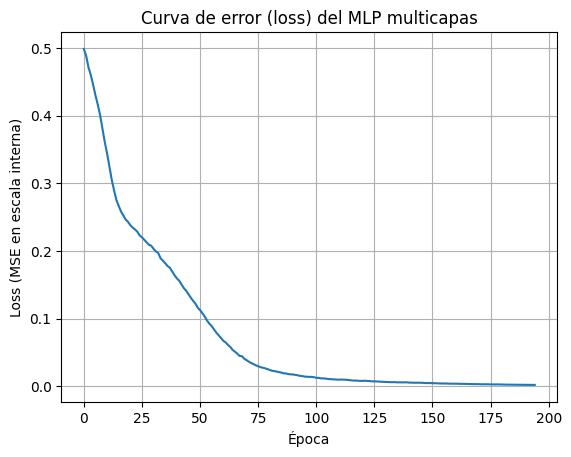


MÉTRICAS EN DATOS DE PRUEBA (regresión):
MSE (error cuadrático medio): 57.5349
MAE (error absoluto medio):  5.6365


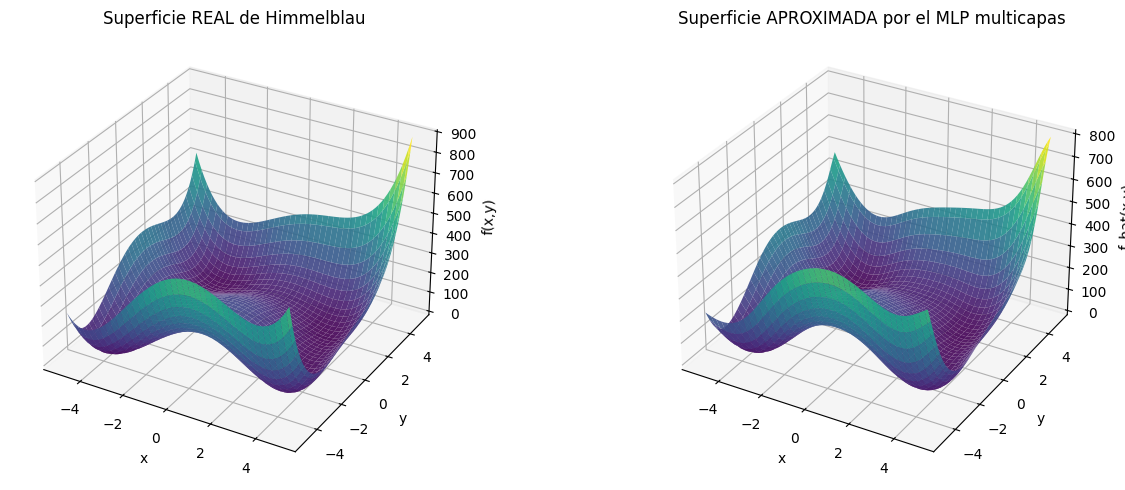

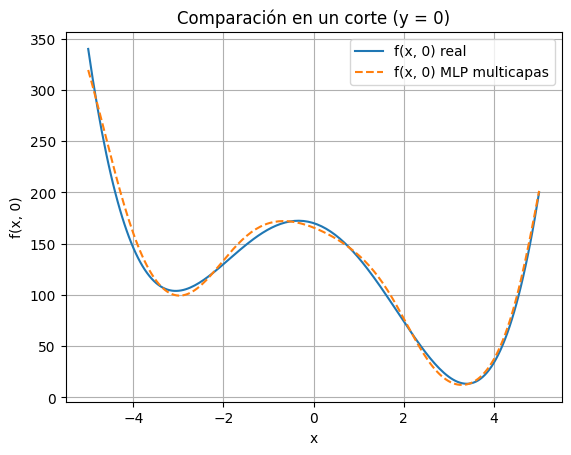

In [1]:
# ============================================
# PASO 1: Cargar librerías
# ============================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor   # MLP para REGRESIÓN (multi-capa)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mpl_toolkits.mplot3d import Axes3D  # para gráficas 3D


# ============================================
# PASO 2: Definir función (Himmelblau)
# f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2
# ============================================
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


# ============================================
# PASO 3: Definir intervalo y generar datos
#    - intervalo para x, y
#    - malla de puntos (grid)
# ============================================
# Intervalo donde queremos aproximar la función
x_min, x_max = -5, 5
y_min, y_max = -5, 5

# Malla para visualización (grid fino)
n_grid = 80
x_lin = np.linspace(x_min, x_max, n_grid)
y_lin = np.linspace(y_min, y_max, n_grid)
Xg, Yg = np.meshgrid(x_lin, y_lin)
Zg = himmelblau(Xg, Yg)

# Datos de entrenamiento: tomamos una malla más gruesa
n_train = 40
x_train_lin = np.linspace(x_min, x_max, n_train)
y_train_lin = np.linspace(y_min, y_max, n_train)
Xt, Yt = np.meshgrid(x_train_lin, y_train_lin)
Zt = himmelblau(Xt, Yt)

# Convertimos a vectores (n_muestras x 2) y (n_muestras,)
X_train_raw = np.column_stack([Xt.ravel(), Yt.ravel()])
y_train_raw = Zt.ravel()

print("Forma de X_train_raw:", X_train_raw.shape)
print("Forma de y_train_raw:", y_train_raw.shape)


# ============================================
# PASO 4: Normalización de datos
# ============================================
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

print("\nEjemplos normalizados (primeras 5 filas):")
print(X_train[:5])
print(y_train[:5])


# ============================================
# PASO 5: Transponer y concatenar la entrada
# (para inspección; el modelo usará X_train usual)
# ============================================
X_train_T = X_train.T
print("\nTranspuesta de X_train (para ver estructura):")
print(X_train_T[:, :5])  # mostramos sólo 5 columnas


# ============================================
# PASO 6: Crear el modelo de la red
# ============================================
# ============================================
# PASO 7: Definir los hiperparámetros del MLP
#   * MULTI-CAPA: varias capas ocultas
#   * hidden_layer_sizes = (neur1, neur2, neur3, ...)
# ============================================

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),   # <-- MULTI-CAPA: 3 capas ocultas
    activation='tanh',                 # función de activación
    solver='adam',                     # optimizador
    learning_rate_init=0.001,          # tasa de aprendizaje
    max_iter=5000,                     # máx. épocas
    random_state=0
)

print("\nEstructura del MLP:")
print(mlp)


# ============================================
# ENTRENAMIENTO DEL MLP
# ============================================
mlp.fit(X_train, y_train)

# ============================================
# PASO 8: Evaluar y graficar el error por época
# (loss_curve_ da el error de entrenamiento en cada iteración)
# ============================================
loss_curve = mlp.loss_curve_
print("\nNúmero de épocas realizadas:", len(loss_curve))

plt.figure()
plt.plot(loss_curve)
plt.title("Curva de error (loss) del MLP multicapas")
plt.xlabel("Época")
plt.ylabel("Loss (MSE en escala interna)")
plt.grid(True)
plt.show()


# ============================================
# PASO 9: Definir los datos de prueba
#    Usamos el grid fino Xg, Yg para ver qué tan bien
#    aprendió la superficie completa
# ============================================
X_test_raw = np.column_stack([Xg.ravel(), Yg.ravel()])
y_test_true = Zg.ravel()

# Normalizamos con los mismos escalares
X_test = scaler_X.transform(X_test_raw)


# ============================================
# PASO 10: Evaluar el modelo y graficar el resultado
# ============================================
# Predicción
y_test_pred_norm = mlp.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_norm.reshape(-1, 1)).ravel()

# Métricas de error (regresión)
mse = mean_squared_error(y_test_true, y_test_pred)
mae = mean_absolute_error(y_test_true, y_test_pred)

print("\nMÉTRICAS EN DATOS DE PRUEBA (regresión):")
print(f"MSE (error cuadrático medio): {mse:.4f}")
print(f"MAE (error absoluto medio):  {mae:.4f}")

# --- Gráfica 3D: superficie real ---
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(Xg, Yg, Zg, cmap='viridis', alpha=0.9)
ax1.set_title("Superficie REAL de Himmelblau")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x,y)")

# --- Gráfica 3D: superficie predicha por el MLP ---
Z_pred_grid = y_test_pred.reshape(Xg.shape)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(Xg, Yg, Z_pred_grid, cmap='viridis', alpha=0.9)
ax2.set_title("Superficie APROXIMADA por el MLP multicapas")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("f_hat(x,y)")

plt.tight_layout()
plt.show()

# --- Gráfica extra: comparación en 2D (corte y vs f) ---
# Tomamos una línea a lo largo de x con y fijo (por ejemplo y = 0)
y_fixed = 0.0
x_line = np.linspace(x_min, x_max, 200)
z_true_line = himmelblau(x_line, y_fixed)

X_line_raw = np.column_stack([x_line, np.full_like(x_line, y_fixed)])
X_line = scaler_X.transform(X_line_raw)
z_pred_line_norm = mlp.predict(X_line)
z_pred_line = scaler_y.inverse_transform(z_pred_line_norm.reshape(-1, 1)).ravel()

plt.figure()
plt.plot(x_line, z_true_line, label="f(x, 0) real")
plt.plot(x_line, z_pred_line, '--', label="f(x, 0) MLP multicapas")
plt.title("Comparación en un corte (y = 0)")
plt.xlabel("x")
plt.ylabel("f(x, 0)")
plt.legend()
plt.grid(True)
plt.show()
